<a href="https://colab.research.google.com/github/sid6155330/t81_558_deep_learning/blob/master/machine_learning_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**Machine Learning 101 with Python**

Dr Jack Yang 

jianliang.yang1@unsw.edu.au

*School of Material Science and Engineering, UNSW*

*Advanced Materials and Manufacturing Futures Institute, UNSW*

July 2020

#*Aims*

Machine learning (ML) and artificial intelligence (AI) are definitively some of the words in hype across the society at the moment. However, views on ML/AI are quite divided. While some are astonished with the power devlivered by the complex neural network models that can solve real problems once seems only solvable through human reasoning, such as AlphaGo, others criticize ML is simply a 'glorified version of curve fitting' and being largely a 'black box'.

At the end of previous workshop ([Visualisation of Covid-19 Data Using Python](https://colab.research.google.com/drive/1gtIWqmfnp4TsXGiEHOiOZ061MNsak9LX#scrollTo=ZRJzanK8aley)), we demonstrate how Python has made ML easily doable with a few lines of Python. In this workshop, we want to build on top of what we demonstrated previously, by using some simple and easy-to-visualize examples to walk through a proper process of optimizing a ML model. 

We hope that, this workshop can open up some of the 'black boxes' in ML to help you gain more understanding on how ML work, and why it is more than just a simple 'curve-fitting'.

#**Imports**

As usual, we will import some of the existing packages for doing the heavy-liftings. We will use ***matplotlib*** for plotting, and ***scikit-learn*** for ML.

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import math

#**Supervised Learning (Regression) - An Introduction**
![alt text](https://drive.google.com/uc?id=1WZts0XRCG2SDQlD0UPl2TLVSaT8M7UGk)

At the first glance, the purpose of ML regression is very similar to curve-fitting. Given a set of $x$'s and $y$'s, we want to *interpolate* the relationship between them in order to obtain a function $y=f^{\mbox{pred}}(x)$, which should be as close to the true function  $y=f^{\mbox{true}}(x)$ as possible. From which we can predict the corresponding $y_{new}$ for a new observable $x_{new}$ as   $y_{new}=f^{\mbox{pred}}(x_{new})$.

However, being called machine **learning**, there is at least one key difference from a standard curve fitting:

In ML, we generally have **no knowledge** what $f(x)$ is needed to fit the observed data, because this is what we are trying to learn. What we have is a set of **probablistic believes** on how the world looks like (i.e. what functions can possibly fit to the data, which is called ***prior***), and the ML algorithm helps us to find out which subset of thses functions have the **highest probability to reproduce the observed relationship** (which is also called the ***posterior***). This is schematically illustrated as follow and we will demonstrate that using an ML method called **Gaussian Processes**.

![alt text](https://drive.google.com/uc?id=1zeVoy2bbF55YtExUORB5TIJCdgqMU0KJ)


#**Setting the Stage - Playing with the Lennard Jones Potential**

In this workshop, we will use Gaussian Process to demonstrate how an ML model can be optimized to learn a very simpe mathematical relationships from a set of obserbales. The true relationship is governed by the physics of a Lennard-Jones potential. Don't worry if you don't know what it is. In a nutshell, it describes the interaction energies between two particles separated at distance $x$, and has a very simple mathematical form:
\begin{equation}
y=-\frac{2a}{x^6}+\frac{b}{x^{12}}.
\end{equation}

Nevertheless, it is sufficient for demonstrating a few key ideas in ML for people who simply wants to get a crack on it!

To set this up, we construct a Python class (or object) to handle a few things in a more pragmatic way.

In [6]:
class LennardJonesian(object):
  """
  This is a class object that helps to define the functional form of the Lennard Jones
  potential, and allows you to calculate the value of the potential given a distances 
  between the two particles.

  To construct a default object, simply call:
  lj = LennardJonesian()
  with the default parameters of a=1 and b=1 (see the __init__ function)

  If you would like to change these parameters, you can initialize a new object, such as
  lj2 = LennardJonesian(a=2,b=1.5)

  """

  def __init__(self,a=1,b=1):
    self.a = a
    self.b = b

  def potential(self,x):
    """
    This function calculate the value of the Lennard Jones potential at a given separation x.
    """
    return -2*self.a/math.pow(x,6)+self.b/math.pow(x,12)

  def plot_analytic_potential(self,n_samples=500,x_start=0.64,x_end=1.64,c='k',label=None):
    """
    This function plots the curve for Lennard Jones potential.
    
    Args:
      xs: a list of x values.
    """
    xs = [x_start+i*(x_end-x_start)/n_samples for i in range(n_samples)]
    plt.plot(xs,[self.potential(i) for i in xs],'-',c=c,label=label,lw=2.5,alpha=0.5)
    plt.plot(xs,[0 for _ in xs],'y:')
    plt.xlabel('$x$',fontsize=20)
    plt.ylabel('$y$',fontsize=20)

  def fake_samples(self,n_samples=500,x_start=0.64,x_end=1.64):
    """
    For the demonstration purpose only, we will generate a set of random samples (x,y)
    that will roughly follow the relationship given by the LJ potential. A random noise
    is added to the y value to make it deviate from the true LJ potential. The idea
    here is to mimic an experimentally/computationally generated database, on which 
    ML will be performed. In reality, the database generating process would be 
    the most laborious and slow part of the process, which cannot be demonstrated
    in a live event.

    Args:
      n_samples: number of samples to be generated, default is 500.
    """
    import random

    #this draws a random float in the range given by [x_start,x_end]
    x_sample = [x_start+random.randrange(0,100000)/100000*(x_end-x_start) for _ in range(n_samples)]
    x_sample = list(sorted(x_sample))

    #this calculate the corresponding y at the x, plus a random noise
    y_sample = [self.potential(x)*(random.randrange(-50,50)/100+1) for x in x_sample]
    return x_sample,y_sample

First of all, let's plot the true function to see what it looks like!

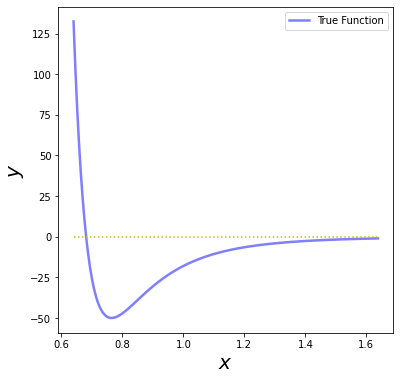

In [7]:
#Set up the aspect ratio of the lot, so I have a big plot to look at
plt.figure(figsize=(6,6))

#This is how I instantiate a new LennardJonesian object. I gave a set of parameters so 
#the graph looks more curely (i.e. hase some interesting feature). 
#Also notice that I assign the created object to a new variable called lj so I can
#get access to different attributes/methods available to the object.
lj=LennardJonesian(a=10,b=2)

#This is how you call the function *plot_analytic_potential* in the object to 
#plot out how this function looks like. The idea of setting up an object, in this
#case, is that I dont need to pass the variables a and b to all other functions
#such as calculating y's from x's and plot data etc etc, because they are known 
#throughout the object once it is constructed. This makes the code easier to read.
lj.plot_analytic_potential(c='b',label='True Function')

plt.legend()

You can probably see that this function, even though it is very simple, it has a part where $y$ changes very rapidly with respect to $x$, and a part where $y$ varies slowly with respect to $x$. This basically reflects the landscape of most mathematical functions that we want to learn/fit, whether or not we are using ML techniques or not. Being able to appreciate how your underlying function 'looks' like will help you a lot with properly tuning the ML model, and this is why we are using a simple function here so we can visualize what is going on.


Now let us generate some data that overall behaves like the Lennard-Jones system, but does not follow a simple curve as shown above. 

This could be the case where:
1. data is measured experimentally where noises are inevitable.
2. data is generated in a high-dimensional space, when it is projected onto $x$, it shows a dominating LJ behaviors but their are additional contributing factors from other dimensions that makes the data deviate from a perfect LJ. 

*REMEMBER*

**In real life, it is this set of data that we will see first and try to learn, not the underlying Lennard-Jones potential, which is the target knowledge to be learned. We only do this in the reverse order here so you can understand the data easier, which, as mentioned about, is quite important for ML to work for you.**

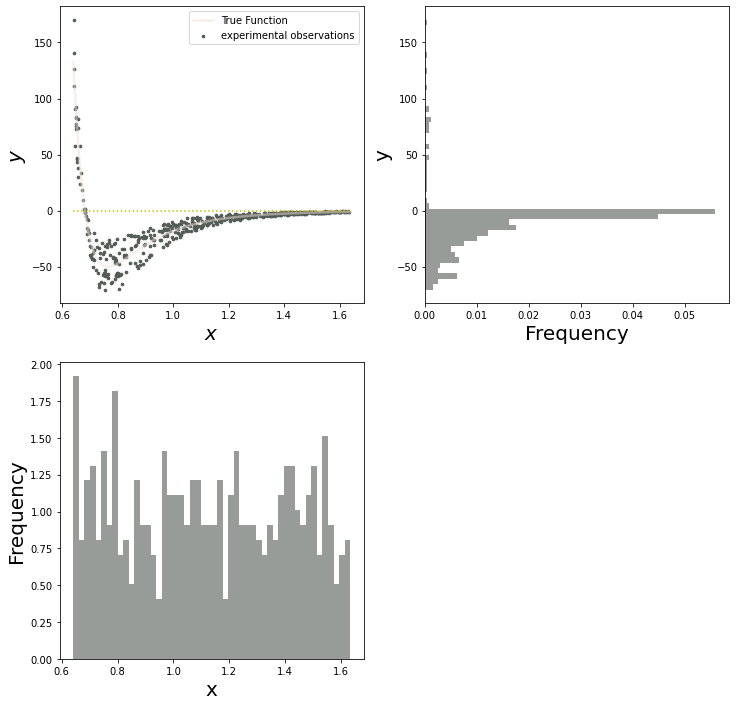

In [8]:
n_samples=500 # this is how many sample we have on our hand, from which we
              # will learn the underlying behaviors

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
lj.plot_analytic_potential(c='#f1e0d6',label='True Function')
x_sample,y_sample=lj.fake_samples(n_samples=n_samples)
#show what are the points being sampled 
plt.scatter(x_sample,y_sample,marker='o',s=7,facecolor='#525b56',label='experimental observations')
plt.legend()

#We also want to have some understanding on the distributions of the data points
#It may come useful when we are trying to understand the accuracy of ML later. 
plt.subplot(2,2,2)
plt.hist(y_sample,bins=50,orientation='horizontal',color='#525b56',alpha=0.6,density=True);
plt.xlabel('Frequency',fontsize=20);
plt.ylabel('y',fontsize=20);

plt.subplot(2,2,3)
plt.hist(x_sample,bins=50,color='#525b56',alpha=0.6,density=True);
plt.ylabel('Frequency',fontsize=20);
plt.xlabel('x',fontsize=20);

#**Initial Learning - Getting Some Idea Where We are Heading**



In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import numpy as np

# The training set

![](https://drive.google.com/uc?id=1wxDTEOEKkINmz8qIt_FDREqZJocKZ0ne)

The first step of the ML process is to extract a portion of the sample for constructing a training set to train the model, where the rest are left for testing/validating the trained model to see how well the model can predict the results of *previously unseen* data.

How to appropriately select the training data has very important implication on the quality of ML-model, which we cannot go into too much details here. For the moment, the training data is simply selected as ****a fraction ($t$%) of the total sample evenly spreaded across $x$****, so $t$ is one of the parameters in our ML model

In [3]:
training_pt_fraction=0.2
num_traing_pts=n_samples*training_pt_fraction
gap=int(n_samples/num_traing_pts)
print(gap)

#these are the x's and the corresponding y's for training the model
x_train=np.array(x_sample[::gap]).reshape(-1, 1)
y_train=np.array(y_sample[::gap]).reshape(-1, 1)

#Plot the training set out and have a look
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
lj.plot_analytic_potential(c='#f1e0d6',label='True Function')
plt.scatter(x_sample,y_sample,marker='o',s=7,facecolor='#525b56',alpha=0.5,label='experimental observations')
plt.scatter(x_train,y_train,marker='o',s=15,facecolor='b',label='training points')
plt.legend()

NameError: ignored

# The Kernel (or the covariance matrix)

*   This is the most critical ingredient in Gaussian Processes.
*   Given two points $(x_1,y_1)$ and $(x_2,y_2)$ in space, the kernel describes the similarity between two points $\mathcal{K}(x_1,x_2)$ based on the distance between them $\mathcal{K}(x_1,x_2)=\mathcal{K}(d(x_1,x_2))$. The idea is that if $x_1$ and $x_2$ are close together, $y_1$ should also be close to $y_2$ (in theory).
*   The kernel therefore encodes *our prior belief on how two data points are similar to each other*, controlled by some parameters.

Here we will be using the Radial Basis Function (RBF) as our kernel, which is a Gaussian function of the distance between two points:
\begin{equation}
\mathcal{K}(x_i,x_j)=\exp\left(-\frac{d(x_i,x_j)^2}{2\ell^2}\right)
\end{equation}
in which $\ell$ is the parameter controlling how correlated are two points in space.

**Note**

* While simple kernel may serve as a starting point for understanding the basics, real problems often require more complex kernels, often tailored designed to better capture the physics behind.
* It is possible to combine multiple kernels to model more complex behaviors in the data.

Now let's first get some impression on what our prior will look like drawn by the RBF kernel with length-scale parameter $\ell$.

In [ ]:
def draw_prior(length_scale):
  #length_scale: variable, the value of which will be given to define
  #              the kernel

  #define a kernel and Gaussian process object by giving it a kernel
  kernel = RBF(length_scale=length_scale) 
  gp = GaussianProcessRegressor(kernel=kernel)

  X_ = np.linspace(0.6, 1.6 ,100) #this is the range of x in which we want to model
  y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)

  #drawing sample functions from the prior probability distribution function, which
  #simply says all functions are equal likely to be drawn
  y_samples = gp.sample_y(X_[:, np.newaxis], 3)

  return X_, y_samples

length_scales=[0.1,0.05,0.001,0.0001]
plt.figure(figsize=(20,4))
for i in range(4):
  x, y = draw_prior(length_scales[i])
  plt.subplot(1,4,i+1)
  plt.plot(x,y,'-')
  plt.xlabel('x',fontsize=20)
  if i==0:
    plt.ylabel('y',fontsize=20)
  plt.title('RBF l='+str(length_scales[i]))

# Initial Fit

Let's first use the four kernels listed above to try fitting our data, using 0.2 as the fraction of the total data to be used as training points. This will allows us to get some idea on what might be a reasonable starting parameter for the RBF kernel. 

Here we will fix the training points across all four parameters, and plot the machine--learned relationships between $x$ and $y$'s.

In [ ]:
def play_around_with_GP(alpha=None):
  length_scales=[1,0.05,0.001,0.0001]
  plt.figure(figsize=(20,5))

  for i in range(4):
    #As above, set up a Gaussian Process object with the kernel we want
    kernel = RBF(length_scale=length_scales[i]) 
    if alpha is None:
      gp = GaussianProcessRegressor(kernel=kernel)
    else:
      gp = GaussianProcessRegressor(kernel=kernel,alpha=alpha)


    #Train our ML models by letting it observing our training set
    gp.fit(x_train,y_train) 

    #Plot routines carried out from above, plot the raw data, training points etc.
    plt.subplot(1,4,i+1)
    lj.plot_analytic_potential(c='#f1e0d6',label='True Function')
    plt.scatter(x_sample,y_sample,marker='o',s=7,facecolor='#525b56',alpha=0.5,label='experimental observations')
    plt.scatter(x_train,y_train,marker='o',s=15,facecolor='b',label='training points')
    
    #now we see what the learned model are by evaluating the functional value at 
    #a range of x's
    y_mean, y_std = gp.predict(np.array(x_sample)[:, np.newaxis], return_std=True)
    plt.plot(x_sample,y_mean,'r-',lw=2,label='ML Approximation')

    plt.title('RBF $l$='+str(length_scales[i]))

    plt.legend()
  plt.tight_layout()

play_around_with_GP(alpha=None)

As you can see from this initial trial, the parameter $\ell$ plays a rather significant role in how well ML can ***surrogate*** a good mathematical realtionship between $x$ and $y$. For the case where 20% of our data are used to train the model, $\ell=0.001$ seems to be a reasonable choice that gives a function which more or less follows the behaviour of a LJ potential. 

However, you can also notice that the learned function is very oscillatory compared to the true LJ function, as the surrogated model tries to go pass the training points ***exactly***. But remember, when we generated the data, we introduced some ***random noises*** into the data to mimick what happens under realistic experimental situations. So we need to tell our ''machine'' that there are noises in the data, and don't try to force itself to reproduce the exact values of the training point. This can be controlled by specifying the noise level through the parameter $\alpha$.

In [ ]:
play_around_with_GP(alpha=0.2)

#**Optimising the model**

# The Error Function

Now, for most of the machine learning models that we will actually deal with, we cannot really inspect the machine-learned model as above to judge the quality of the model. This is because the problem we are trying to deal with are in *high-dimensional space* and often difficult to visualize. (Although we can get some help from **Unsupervised Machine Learning**, we won't go into this and make the problem too complicated).

The most common way for us to optimise the model is to monitor the change of **error function** as we scan through a set of parameters to help us finding the best choice. The  **error function** simply measures the difference between the predicted value from the ML model and the true value. 

Here we use a slightly more complicated error function to make it numerically more tractable.

\begin{equation}
\mbox{Error Function}=\frac{\sum_{i=1}^{N_{test}}\left|E^{ref}_{i}-E^{GP}_{i}\right|}{\sum_{i=1}^{N_{test}}\left|E^{ref}_{i}-\overline{E^{ref}}\right|},
\end{equation}

Moreover, for each $\ell$, we will train over 5 set of different training set randomly sampled from the data and take the average of it.

# Optimising the length scale $\ell$ for RBF kernel

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#Define a series of parameters that we are going to scan through
length_scales=np.logspace(-4, 1, num=150)


def get_train_test_set(x_sample,y_sample,training_pt_fraction=0.2):
  """
  Define a helper function to randomly select a set of points for training
  and validation. The portion of the training points is specified by 
  the training_pt_fraction.
  """
  import random
  ids=[i for i in range(len(x_sample))]
  train_ids = random.sample(ids, int(training_pt_fraction*len(x_sample)))
  test_ids = [i for i in ids if i not in train_ids]

  training_set_x = [x_sample[i] for i in train_ids]
  training_set_y = [y_sample[i] for i in train_ids]
  test_set_x =  [x_sample[i] for i in test_ids]
  test_set_y =  [y_sample[i] for i in test_ids]
  return np.array(training_set_x).reshape(-1, 1), np.array(training_set_y).reshape(-1, 1), np.array(test_set_x).reshape(-1, 1), np.array(test_set_y).reshape(-1, 1)

y_mean = np.mean(y_sample)

mean_error = []

for i in range(len(length_scales)):
  kernel = RBF(length_scale=length_scales[i]) 

  #note that we fix alpha=0.2 here, of course, it may also be a parameter to be optimized
  gp = GaussianProcessRegressor(kernel=kernel)

  this_error = []
  for j in range(5): # test the same length scale 5 times to collect some statistics
    x_train,y_train,x_test,y_test = get_train_test_set(x_sample,y_sample)
    gp.fit(x_train,y_train)
    y_predict = gp.predict(x_test, return_std=False)

    #calculate the error function
    nominator = sum([abs(y_predict[k]-y_test[k]) for k in range(len(y_predict))])
    denominator = sum([abs(y_predict[k]-y_mean) for k in range(len(y_predict))])
    error = nominator/denominator
    this_error.append(error)

  mean_error.append(np.mean(error))


#plot the training curve for optimizing ell
plt.plot(length_scales,mean_error,'ro')
plt.xscale('log')

plt.xlabel("length_scale")
plt.ylabel("Error function")

# How much data should we use to train the model?

One of the most important parameter to choose for ML, which is independent from what exactly the ML method is, would be the number of data points that is needed to properly train an ML model.

It may be natural to think that the more data to train the model, the better the quality it would be. What this belief reflects is really a competition between two of the followings:

* The error on training set (i.e. how well does the model reproduce the data that it was trained upon?), and 
* The error on validation/test set (i.e. how well can the model predict the values of the unseen data?)

Let's look at how our model behaves when we change the training set fraction while keeping $\ell$ and $\alpha$ fixed.

In [ ]:
training_set_fractions = [0.1+0.0125*i for i in range(66)]

mean_error_training=[]
mean_error_validation=[]

y_mean = np.mean(y_sample)

for tf in training_set_fractions:
  kernel = RBF(length_scale=length_scales[i]) 

  #note that we fix alpha=0.2 here, of course
  gp = GaussianProcessRegressor(kernel=kernel,alpha=0.2)

  this_training_error = []
  this_validation_error = []
  for j in range(5): # test the same length scale 5 times to collect some statistics
    x_train,y_train,x_test,y_test = get_train_test_set(x_sample,y_sample,training_pt_fraction=tf)
    gp.fit(x_train,y_train)

    #error for the training set
    y_predict = gp.predict(x_train, return_std=False)
    nominator = sum([abs(y_predict[k]-y_train[k]) for k in range(len(y_predict))])
    denominator = sum([abs(y_predict[k]-y_mean) for k in range(len(y_predict))])
    error = nominator/denominator
    this_training_error.append(error)

    #error for the validation set
    y_predict = gp.predict(x_test, return_std=False)
    nominator = sum([abs(y_predict[k]-y_test[k]) for k in range(len(y_predict))])
    denominator = sum([abs(y_predict[k]-y_mean) for k in range(len(y_predict))])
    error = nominator/denominator
    this_validation_error.append(error)

  mean_error_training.append(np.mean(this_training_error))
  mean_error_validation.append(np.mean(this_validation_error))

plt.plot(training_set_fractions,mean_error_training,'bo-',label='Training Error')
plt.plot(training_set_fractions,mean_error_validation,'ro-',label='Validation Error')
plt.legend()
plt.xlabel("Training Set Fraction")
plt.ylabel("Error function")
plt.yscale('log')

Note that here we are only using a simple code to demonstrate why you should be testing your train/test set partitions to tune the performances of your ML model. In real work, this is more involved, as there are statistical concerns on how to choose them such that the evaulations are statically significant. 

[Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) is a pragmatic way on how this can be properly done to avoid under-/over-training an ML model. Practically it will be too involved to go through C.V. in this workshop, and I encourage you to read the documentations if you are seriously thinking about doing ML! 



#**Enhaced Sampling - A More Advanced Topic**

You may have noticed that when we first generated the samples $\left\{(x_{i},y_{i})\vert y_{i}=\mbox{LJ} (x_{i})+\varepsilon_{i}\right\}$, where $\varepsilon_{i}$ is a random noise, all the $x$'s are rather uniformly smapled, but the $y$'s are heavily peaked at $y\approx 0$, because of the unique shape of the Lennard-Jones potential. 

For many applications, it is often the $y$'s that we want to sample more evenly. A typical application scenario will be in the experiments, where we can only control the experimental parameters $x$ to get some results $y$. After performing $N$ experiments, we saw overwhelmingly results concentrated on a few points, with a few outliers. The question we want to ask is then, how can we finely tune our input parameter $x$ so we can observe more data around the outliers?

This is an extremely difficult task if we dont really know how $y$ is related to $x$ from random experimental observations. But if we can use ML to learn the ***inverse relationship from $y$ back to $x$***, then it gives us a handle to more uniformly sample $y$ and then somehow infer back to a probable $x$ from which the desired $y$ can be obtained. 

We will try to demonstrate this with the code below.


In [ ]:
x_predict_y_uniform=[0 for _ in range(10000)]
for i in range(10):
  gp = GaussianProcessRegressor(kernel=kernel,alpha=0.2) 
  x_train,y_train,x_test,y_test = get_train_test_set(x_sample,y_sample,training_pt_fraction=0.5)

  #We train a model to learn x from y rather than to learn y from x
  gp.fit(y_train,x_train)
  x_predict = gp.predict(np.array(y_sample).reshape(-1, 1) , return_std=False)

  import random

  #now we draw a uniform set of samples from y and try to predict the corresponding x
  y_uniform=[-60+random.randrange(0,210) for _ in range(10000)]
  _x_predict_y_uniform = gp.predict(np.array(y_uniform).reshape(-1, 1) , return_std=False)
  
  x_predict_y_uniform += _x_predict_y_uniform[:,0]/10

  if i==0:
    plt.figure(figsize=(8,8))
    plt.subplot(2,2,1)
    plt.scatter(x_sample,y_sample,marker='o',s=7,facecolor='#525b56',alpha=0.5,label='experimental observations')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.xlim([0.4,1.2])
    plt.plot(_x_predict_y_uniform,y_uniform,'b.',label='ML learned relationship')
    plt.legend()

plt.subplot(2,2,2)

plt.hist(y_uniform,bins=50,orientation='horizontal',color='#525b56',alpha=0.6,density=True);
plt.title("Probability Distribution in $y$")

plt.subplot(2,2,3)

#Here we will plot the distribution of x, if, we drawn samples of x according to 
#   such a distribution, then we will have some confidence that it will lead to
#   a more uniformly distributed y
plt.hist(list(x_predict_y_uniform),bins=50,color='#525b56',alpha=0.6,density=True);
plt.title("Probability Distribution in $x$ averaged 10 times")
plt.xlim([0.4,1.2])

plt.tight_layout()

As you can see from above, after averaging 10 trained GP models, the optimum distribution of $x$ that leads to a uniform samling of $y$ is a Gaussian type distribution centered around 0.75. If now we draw samples of $x$ from this learned distribution, we would have a better chance to sample the region of $y$ where the data changes most rapidly.

# **Wrapping Up**

So, we have come to the end of this quick introductory tutorial on supervised machine-learning using scikit-learn. We have gone through the process of training the ML model, which is more or less common to many mature ML techniques that has been developed. However, to really make ML work for you, there are still many nity-gritties that you need to consider/work on, so you can get obtained the best outcomes. Some of the things that you need to think about include:

* What kind of data do I have, how do I get the data?
* How do I represent the data mathematically so something useful can be learned from it? (This itself is a big research topic in ML itself)
* Have I trained the model properly? Is there anything I can do to train the model better?
* And lastly, what can I get out from the ML model? Canit provide me with some new insights that were difficult to be discovered otherwise?
